##Importando as Bibliotecas

In [72]:
# Importando as bibliotecas
import pandas as pd
import numpy as np

# Matplotlib e seaborn serão usadas para visualização dos dados.
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn será usado para avaliar acurácia e erro dos modelos.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

##Aquisição dos Dados


In [73]:
#Obtendo os dados, transformando a coluna de data para formato padrão
df = pd.read_csv('Dados_Ibovespa_jan15_nov25.csv', parse_dates=['Data'], dayfirst=True)
df.rename(columns={'Data' : 'ds', 'Último': 'fechamento', 'Abertura': 'abertura', 'Máxima': 'max', 'Mínima': 'min', 'Vol.':'vol', 'Var%': 'var'}, inplace=True)
df.drop(columns={'var', 'vol'}, inplace=True)
df.head()

,ds,fechamento,abertura,max,min
0,2025-12-01,158.611,159.073,159.224,158.029
1,2025-11-28,159.072,158.358,159.689,158.078
2,2025-11-27,158.360,158.554,158.864,158.167
3,2025-11-26,158.555,155.915,158.714,155.914
4,2025-11-25,155.910,155.278,156.373,154.821


In [74]:
#ordenamos os valores em tempo crescente, nosso df inicial estava decrescente.
#Assim, poderemos aplicar a função diff() para calcular a diferençã entre a linha atual e a linha anterior, obtendo assim, a tendência.
df = df.sort_values(by='ds', ascending=True).reset_index(drop=True)
df['y']= df['fechamento'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df.head()

,ds,fechamento,abertura,max,min,y
0,2015-01-02,48.512,50.004,50.004,48.345,0
1,2015-01-05,47.517,48.512,48.512,47.264,-1
2,2015-01-06,48.001,47.517,48.061,47.338,1
3,2015-01-07,49.463,48.006,49.882,48.006,1
4,2015-01-08,49.943,49.463,50.261,49.017,1


Verificação de sazonalidade, teste ADF e verificação de diferenciação realizados no notebook Fase 2.

##Inclusão de novas features e diferenciação dos dados do DataFrame

In [75]:
df['amplitude']=df['max']-df['min']
df['delta']=df['fechamento']-df['abertura']
df['variacao']=df['delta']/df['abertura']

df['volatilidadeS'] = df['delta'].rolling(window=5).std()
df['volatilidadeM'] = df['delta'].rolling(window=22).std()
df['volatilidadeT'] = df['delta'].rolling(window=66).std()
df['volatilidadeSE'] = df['delta'].rolling(window=132).std()
df['volatilidadeA'] = df['delta'].rolling(window=264).std()

df['maS']=df['fechamento'].rolling(window=5).mean()
df['maM']=df['fechamento'].rolling(window=22).mean()
df['maT']=df['fechamento'].rolling(window=66).mean()
df['maSE']=df['fechamento'].rolling(window=132).mean()
df['maA']=df['fechamento'].rolling(window=264).mean()

df.head()

,ds,fechamento,abertura,max,min,y,amplitude,delta,variacao,volatilidadeS,volatilidadeM,volatilidadeT,volatilidadeSE,volatilidadeA,maS,maM,maT,maSE,maA
0,2015-01-02,48.512,50.004,50.004,48.345,0,1.659,-1.492,-0.029838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,47.517,48.512,48.512,47.264,-1,1.248,-0.995,-0.020510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,48.001,47.517,48.061,47.338,1,0.723,0.484,0.010186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,49.463,48.006,49.882,48.006,1,1.876,1.457,0.030350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,49.943,49.463,50.261,49.017,1,1.244,0.480,0.009704,1.204442,NaN,NaN,NaN,NaN,48.6872,NaN,NaN,NaN,NaN


In [76]:
# Realizar a diferenciação em todas as colunas, exceto 'ds' e 'y'
df_diff = df.copy()
cols_to_diff = [col for col in df_diff.columns if col not in ['ds', 'y']]
df_diff[cols_to_diff] = df_diff[cols_to_diff].diff()

df_diff = df_diff.dropna()

# Reordenar as colunas para ter 'ds' e 'y' no início
cols = ['ds', 'y'] + [col for col in df_diff.columns if col not in ['ds', 'y']]
df_diff = df_diff[cols]

df_diff.reset_index(drop=True, inplace=True)
df_diff.head()

,ds,y,fechamento,abertura,max,min,amplitude,delta,variacao,volatilidadeS,volatilidadeM,volatilidadeT,volatilidadeSE,volatilidadeA,maS,maM,maT,maSE,maA
0,2016-01-29,1,1.776,0.259,1.306,0.639,0.667,1.517,0.039221,0.349205,0.128567,0.037932,0.017703,0.003088,0.5378,-0.164045,-0.101076,-0.095939,-0.030705
1,2016-02-01,1,0.164,1.762,0.164,1.103,-0.939,-1.598,-0.041557,0.010075,0.003466,0.000757,-0.001700,-0.002393,0.5078,-0.145182,-0.097818,-0.089182,-0.026314
2,2016-02-02,-1,-1.974,0.167,-0.006,-1.142,1.136,-2.141,-0.052798,0.515778,0.102396,0.027691,0.015628,0.009296,0.2198,-0.229909,-0.139030,-0.098515,-0.035625
3,2016-02-03,1,0.993,-1.967,-0.838,0.001,-0.839,2.960,0.074217,0.014767,0.041662,0.012652,0.005869,-0.003114,0.2426,-0.170955,-0.121333,-0.090038,-0.037402
4,2016-02-04,1,1.233,0.992,1.718,0.992,0.726,0.241,0.005444,0.068676,0.017851,0.016956,0.007439,0.003567,0.4384,-0.059955,-0.096773,-0.076470,-0.034549


##Criando funções para métricas de avaliação dos modelos

In [77]:
#Função WMAPE para cálculo do erro percentual absoluto através de pesos - Weighted Mean Absloute Percentage Error
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum()/ np.abs(y_true).sum()

In [78]:
#função para calcular a acuracia direcional

def calcular_acuracia_direcional(df, col_data='ds', col_real='y_test', col_previsto='y_pred'):
#Parâmetros:
#     - df (pd.DataFrame): DataFrame contendo as colunas de data, valor real e valor previsto.
#     - col_data (str): Nome da coluna de datas.
#     - col_real (str): Nome da coluna com os valores reais.
#     - col_previsto (str): Nome da coluna com os valores previstos.

    df = df.sort_values(by=col_data).reset_index(drop=True)

    df['direcao_real'] = np.sign(df[col_real] - df[col_real].shift(1)) #compara valor real do dia com valor real do dia anterior
    df['direcao_prevista'] = np.sign(df[col_previsto] - df[col_previsto].shift(1)) #compara valor previsto do dia com valor previsto para o dia anterior

    df_filtrado = df.dropna()
#   df_filtrado = df_filtrado[df_filtrado['direcao_real'] != 0]

    if not df_filtrado.empty:
        acuracia = accuracy_score(df_filtrado['direcao_real'], df_filtrado['direcao_prevista'])
        return acuracia
    else:
        return np.nan


##Previsões com Modelos utilizando Feature Lagged (d-n) -- n=1

Podemos utilizar o valor de hoje para prever amanhã -- features:

d = fechamento, abertura, max, min
d+1 = desejamos descobrir o fechamento
Utilizaremos as features deslocadas (d-1). Sempre se referindo ao dia anterior, com exceção da abertura - esta feature já sabemos no início do dia, pois ela corresponde ao fechamento d-1

y --> variável target
fechamento, abertura, max, min deslocadas de d-1 serão nossas features

In [79]:
# Incluir features defasadas (lagged features) nos dataframes
df_lagged=df_diff.copy()
n_lags = 1 # Número de dias anteriores a serem incluídos como features

# Criar features defasadas para todas as colunas relevantes
#Não iremos defasar a abertura, pois já temos este dado no início do dia. Ele é valor de fechamento do dia anterior.
for col in ['y', 'fechamento', 'max', 'min', 'amplitude', 'delta', 'variacao', 'volatilidadeS', 'volatilidadeM', 'volatilidadeT', 'volatilidadeSE', 'volatilidadeA', 'maS', 'maM', 'maT', 'maSE', 'maA']:
    for i in range(1, n_lags + 1):
        df_lagged[f'{col}_lag_{i}'] = df_lagged[col].shift(i)

df_lagged.dropna(inplace=True)
df_lagged.head()

,ds,y,fechamento,abertura,max,min,amplitude,delta,variacao,volatilidadeS,...,volatilidadeS_lag_1,volatilidadeM_lag_1,volatilidadeT_lag_1,volatilidadeSE_lag_1,volatilidadeA_lag_1,maS_lag_1,maM_lag_1,maT_lag_1,maSE_lag_1,maA_lag_1
1,2016-02-01,1,0.164,1.762,0.164,1.103,-0.939,-1.598,-0.041557,0.010075,...,0.349205,0.128567,0.037932,0.017703,0.003088,0.5378,-0.164045,-0.101076,-0.095939,-0.030705
2,2016-02-02,-1,-1.974,0.167,-0.006,-1.142,1.136,-2.141,-0.052798,0.515778,...,0.010075,0.003466,0.000757,-0.001700,-0.002393,0.5078,-0.145182,-0.097818,-0.089182,-0.026314
3,2016-02-03,1,0.993,-1.967,-0.838,0.001,-0.839,2.960,0.074217,0.014767,...,0.515778,0.102396,0.027691,0.015628,0.009296,0.2198,-0.229909,-0.139030,-0.098515,-0.035625
4,2016-02-04,1,1.233,0.992,1.718,0.992,0.726,0.241,0.005444,0.068676,...,0.014767,0.041662,0.012652,0.005869,-0.003114,0.2426,-0.170955,-0.121333,-0.090038,-0.037402
5,2016-02-05,-1,-0.230,1.223,-0.195,0.977,-1.172,-1.453,-0.036536,-0.194608,...,0.068676,0.017851,0.016956,0.007439,0.003567,0.4384,-0.059955,-0.096773,-0.076470,-0.034549


Agora, retiraremos as colunas 'max', 'min', 'amplitude', 'delta', 'variacao', 'volatilidade (todas)', 'ma (todas)' que não foram defasadas. Assim, poderemos prever o dia de hoje, com base no dia de ontem. A coluna abertura, não iremos defasar, pois no início do dia, temos o valor de abertura.

In [80]:
df_lagged.drop(columns=['max', 'min', 'amplitude', 'delta', 'variacao', 'volatilidadeS', 'volatilidadeM', 'volatilidadeT', 'volatilidadeSE', 'volatilidadeA', 'maS', 'maM', 'maT', 'maSE', 'maA'], inplace=True)
df_lagged.head()

,ds,y,fechamento,abertura,y_lag_1,fechamento_lag_1,max_lag_1,min_lag_1,amplitude_lag_1,delta_lag_1,...,volatilidadeS_lag_1,volatilidadeM_lag_1,volatilidadeT_lag_1,volatilidadeSE_lag_1,volatilidadeA_lag_1,maS_lag_1,maM_lag_1,maT_lag_1,maSE_lag_1,maA_lag_1
1,2016-02-01,1,0.164,1.762,1.0,1.776,1.306,0.639,0.667,1.517,...,0.349205,0.128567,0.037932,0.017703,0.003088,0.5378,-0.164045,-0.101076,-0.095939,-0.030705
2,2016-02-02,-1,-1.974,0.167,1.0,0.164,0.164,1.103,-0.939,-1.598,...,0.010075,0.003466,0.000757,-0.001700,-0.002393,0.5078,-0.145182,-0.097818,-0.089182,-0.026314
3,2016-02-03,1,0.993,-1.967,-1.0,-1.974,-0.006,-1.142,1.136,-2.141,...,0.515778,0.102396,0.027691,0.015628,0.009296,0.2198,-0.229909,-0.139030,-0.098515,-0.035625
4,2016-02-04,1,1.233,0.992,1.0,0.993,-0.838,0.001,-0.839,2.960,...,0.014767,0.041662,0.012652,0.005869,-0.003114,0.2426,-0.170955,-0.121333,-0.090038,-0.037402
5,2016-02-05,-1,-0.230,1.223,1.0,1.233,1.718,0.992,0.726,0.241,...,0.068676,0.017851,0.016956,0.007439,0.003567,0.4384,-0.059955,-0.096773,-0.076470,-0.034549


##Teste dos Modelos

Para os modelos de regressão, classificaremos a partir da coluna 'fechamento' e em seguida, verificaremos a acurácia direcional comparando com o real.
Determinando a janela temporal de treino e teste
Escolhemos o último mês, conforme orientações do desafio 2.

In [81]:
treino = df_lagged.loc[(df_lagged['ds'] >= '2022-01-01') & (df_lagged['ds'] < '2025-11-03')]
teste = df_lagged.loc[(df_lagged['ds'] >= '2025-11-03') & (df_lagged['ds'] <= '2025-12-01')]

In [82]:
#Determinando análise com variáveis independentes --> abertura, máxima e mínima.
#Variável target (y) -> fechamento
X_treino_R = treino.drop(columns=['ds','fechamento', 'y'])
y_treino_R = treino['fechamento']

X_teste_R = teste.drop(columns=['ds','fechamento', 'y'])
y_teste_R = teste['fechamento']

print('X_treino:', X_treino_R.shape)
print('X_teste:', X_teste_R.shape)
print('y_treino:', y_treino_R.shape)
print('y_teste:', y_teste_R.shape)

X_treino: (960, 18)
X_teste: (20, 18)
y_treino: (960,)
y_teste: (20,)


## Random Forest Regressor

--- Random Forest Regressor ---
Métricas de Erro do Modelo Random Forest

Erro Quadrático Médio (MSE): 1.680
Raiz do Erro Quadrático Médio (RMSE): 1.296
R² Score: -0.456
Erro Médio Absoluto (MAE): 0.932
Erro Percentual Absoluto Médio (MAPE): 151.16%
Weighted Mean Absloute Percentage Error (WMAPE): 106.52%

Random Forest Regressor Directional Accuracy: 63.16%


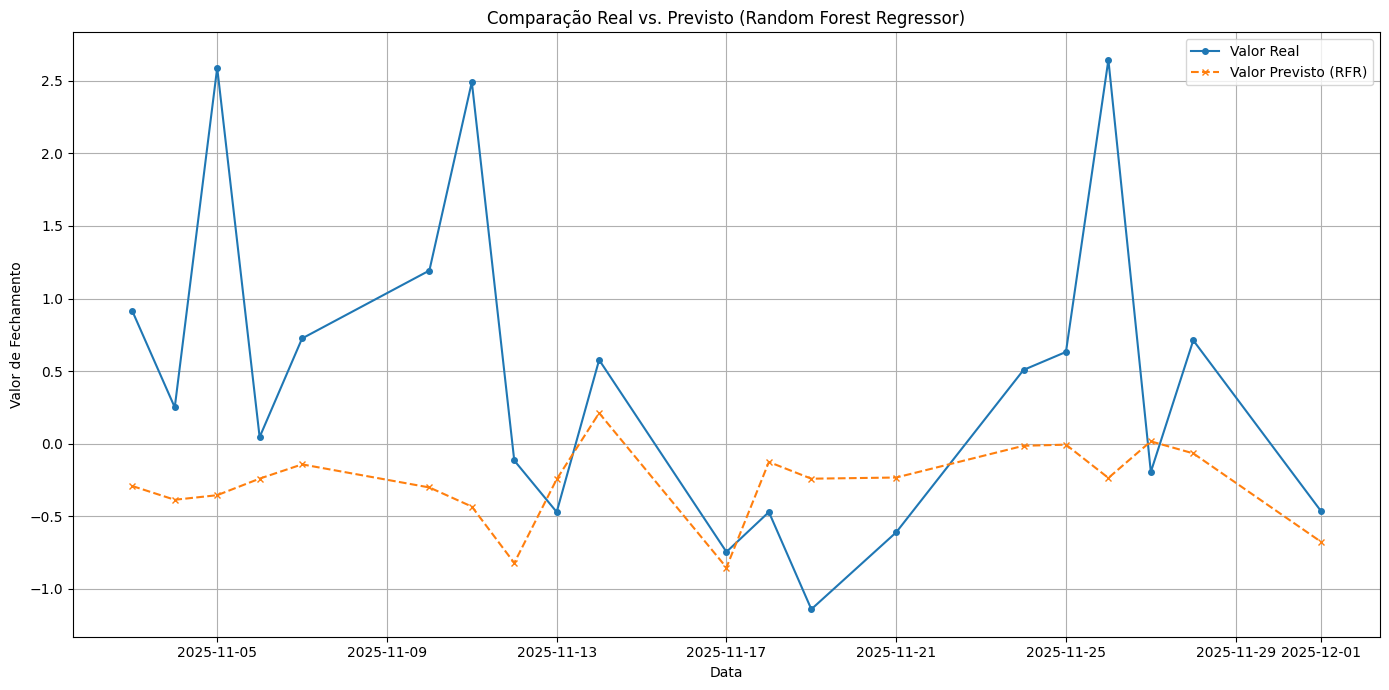

In [83]:
print("--- Random Forest Regressor ---")
model = RandomForestRegressor(random_state=42)
model.fit(X_treino_R, y_treino_R)
y_pred_RFR = model.predict(X_teste_R)

print('Métricas de Erro do Modelo Random Forest\n')

mse_RFR = mean_squared_error(y_teste_R, y_pred_RFR)
rmse_RFR = np.sqrt(mse_RFR)
r2_RFR = r2_score(y_teste_R, y_pred_RFR)
mae_RFR = mean_absolute_error(y_teste_R, y_pred_RFR)
mape_RFR = mean_absolute_percentage_error(y_teste_R, y_pred_RFR)
wmape_RFR = wmape(y_teste_R, y_pred_RFR)

print(f'Erro Quadrático Médio (MSE): {mse_RFR:.3f}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse_RFR:.3f}')
print(f'R² Score: {r2_RFR:.3f}')
print(f'Erro Médio Absoluto (MAE): {mae_RFR:.3f}')
print(f'Erro Percentual Absoluto Médio (MAPE): {mape_RFR:.2%}')
print(f'Weighted Mean Absloute Percentage Error (WMAPE): {wmape_RFR:.2%}')

results_df_RFR = pd.DataFrame({'ds': teste['ds'], 'y_teste': y_teste_R, 'y_pred': y_pred_RFR})
results_df_RFR = results_df_RFR.sort_values(by='ds').reset_index(drop=True)
acuracia_RFR = calcular_acuracia_direcional(results_df_RFR, col_data='ds', col_real='y_teste', col_previsto='y_pred')
print(f"\nRandom Forest Regressor Directional Accuracy: {acuracia_RFR:.2%}")

# Visualizando a comparação entre valores reais e previstos para o modelo Random Forest Regressor
plt.figure(figsize=(14, 7))
plt.plot(results_df_RFR['ds'], results_df_RFR['y_teste'], label='Valor Real', marker='o', linestyle='-', markersize=4)
plt.plot(results_df_RFR['ds'], results_df_RFR['y_pred'], label='Valor Previsto (RFR)', marker='x', linestyle='--', markersize=4)

plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.title('Comparação Real vs. Previsto (Random Forest Regressor)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Gradient Boosting - XG Boost

--- XG Boost ---
Métricas de Erro do Modelo XGBoost

Erro Quadrático Médio (MSE): 2.180
Raiz do Erro Quadrático Médio (RMSE): 1.476
R² Score: -0.889
Erro Médio Absoluto (MAE): 1.073
Erro Percentual Absoluto Médio (MAPE): 168.66%
Weighted Mean Absloute Percentage Error (WMAPE): 122.69%

XG Boost Directional Accuracy: 68.42%


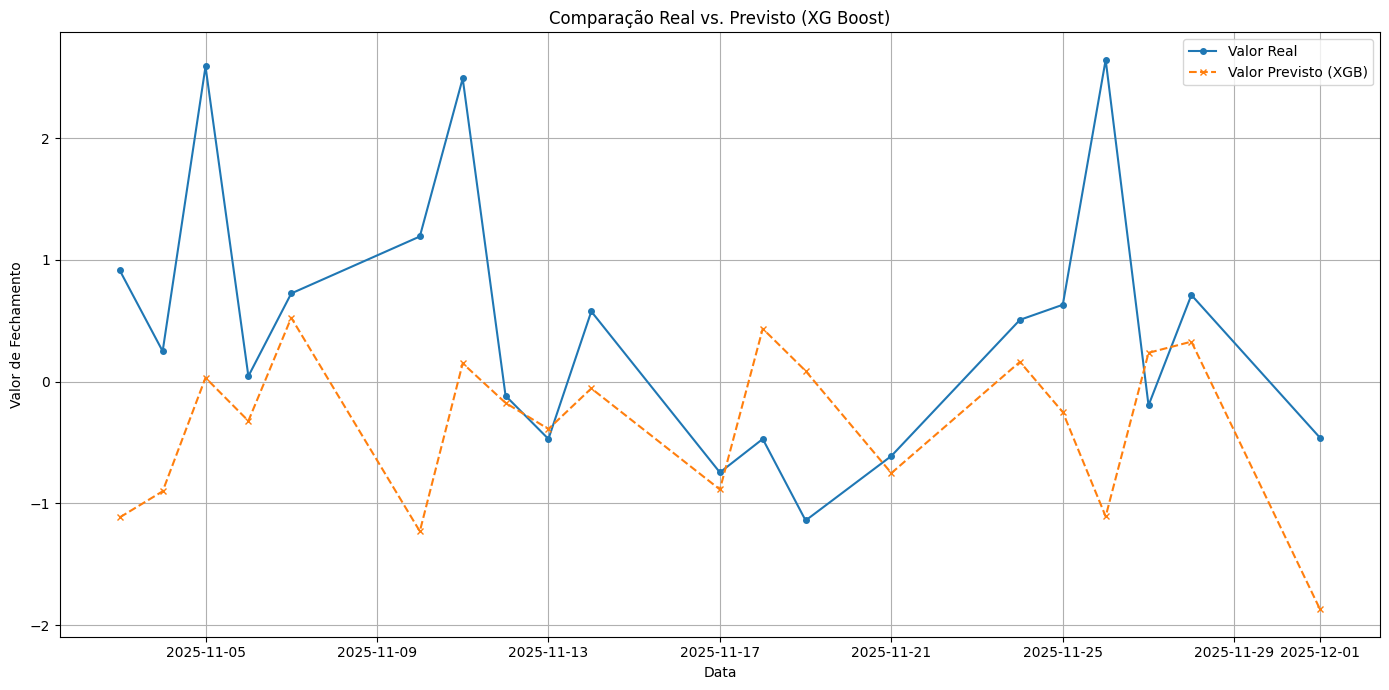

In [84]:
print("--- XG Boost ---")

modelo = xgb.XGBRegressor( objective='reg:squarederror',
    colsample_bytree=1,
    learning_rate=0.9,
    max_depth=3,
    alpha=10,
    n_estimators=100,
    random_state=42
)

modelo.fit(X_treino_R, y_treino_R)
y_pred_XGB = modelo.predict(X_teste_R)

print('Métricas de Erro do Modelo XGBoost\n')

mse_XGB = mean_squared_error(y_teste_R, y_pred_XGB)
rmse_XGB = np.sqrt(mse_XGB)
r2_XGB = r2_score(y_teste_R, y_pred_XGB)
mae_XGB = mean_absolute_error(y_teste_R, y_pred_XGB)
mape_XGB = mean_absolute_percentage_error(y_teste_R, y_pred_XGB)
wmape_XGB = wmape(y_teste_R, y_pred_XGB)

print(f'Erro Quadrático Médio (MSE): {mse_XGB:.3f}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse_XGB:.3f}')
print(f'R² Score: {r2_XGB:.3f}')
print(f'Erro Médio Absoluto (MAE): {mae_XGB:.3f}')
print(f'Erro Percentual Absoluto Médio (MAPE): {mape_XGB:.2%}')
print(f'Weighted Mean Absloute Percentage Error (WMAPE): {wmape_XGB:.2%}')

results_df_XGB = pd.DataFrame({'ds': teste['ds'], 'y_teste': y_teste_R, 'y_pred': y_pred_XGB})
results_df_XGB = results_df_XGB.reset_index(drop=True)
acuracia_XGB = calcular_acuracia_direcional(results_df_XGB, col_data='ds', col_real='y_teste', col_previsto='y_pred')
print(f"\nXG Boost Directional Accuracy: {acuracia_XGB:.2%}")

# Visualizando a comparação entre valores reais e previstos para o modelo XGBoost
plt.figure(figsize=(14, 7))
plt.plot(results_df_XGB['ds'], results_df_XGB['y_teste'], label='Valor Real', marker='o', linestyle='-', markersize=4)
plt.plot(results_df_XGB['ds'], results_df_XGB['y_pred'], label='Valor Previsto (XGB)', marker='x', linestyle='--', markersize=4)

plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.title('Comparação Real vs. Previsto (XG Boost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##JobLib

In [85]:
import joblib

In [86]:
joblib.dump(model, 'modelo_RFR.joblib')

['modelo_RFR.joblib']

In [87]:
joblib.dump(modelo, 'modelo_XGB.joblib')

['modelo_XGB.joblib']